In [26]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os, sys

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

In [29]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

In [30]:
sys.path.append(MODULES_PATH)

In [55]:
from active_learning import Config, AcquisitionFunction, Pool
from wrapper import McDropout, MomentPropagation
from models import setup_growth, fchollet_cnn
from data import BenchmarkData, DataSetType
from mp.MomentPropagation import MP

In [32]:
mnist_path = os.path.join(DATASET_PATH, "mnist")
dataset = BenchmarkData(DataSetType.MNIST, mnist_path)

In [33]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [34]:
base_model = fchollet_cnn(output=10)

In [35]:
seed = 90231
np.random.seed(seed)
tf.random.set_seed(seed)

### Split data

In [36]:
x_train, x_test, y_train, y_test = train_test_split(dataset.inputs, dataset.targets, test_size=10000)

In [37]:
len(x_train)

60000

In [38]:
pool = Pool(x_train, y_train)

### Define Models

In [39]:
%autoreload 2
fit_params = {"epochs": 2, "batch_size": 10}
compile_params = {"optimizer": "adam", "loss": "sparse_categorical_crossentropy", "metrics": [keras.metrics.SparseCategoricalAccuracy()]}

# Define MC Dropout model
mc_model = McDropout(base_model, config=Config(
    fit=fit_params,
    query={"sample_size": 25},
    evaluate={"sample_size": 25}
))
mc_model.compile(**compile_params)

# Define Moment Propagation model
mp_model = MomentPropagation(base_model, config=Config(
    fit=fit_params
))
mp_model.compile(**compile_params)

In [40]:
mc_model.fit(x_train, y_train)

Epoch 1/2
6000/6000 [==============================] - 19s 3ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9447
Epoch 2/2
6000/6000 [==============================] - 19s 3ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9751


In [41]:
mp_model.fit(x_train, y_train)

Epoch 1/2
6000/6000 [==============================] - 19s 3ms/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9814
Epoch 2/2
6000/6000 [==============================] - 19s 3ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9840


In [42]:
mc_model.evaluate(x_test[:10], y_test[:10])

{'loss': 0.009422507, 'accuracy': 0.99}

In [43]:
mp_model.evaluate(x_test[:10], y_test[:10])

{'loss': 0.0053479476, 'accuracy': 1.0}

### Try BALD acquisition

In [44]:
mc_bald = mc_model.get_query_fn("bald")
mc_bald(x_train[:100], sample_size=100)

array([ 8.46402108e-05,  3.90798599e-03,  9.60496836e-05,  1.44511461e-04,
        1.59085356e-03,  1.44567303e-02,  3.55356038e-02,  5.87436929e-03,
        2.87884707e-03,  5.44892158e-04,  3.40347737e-02,  7.95551836e-02,
       -3.59723344e-08,  1.12118749e-02,  5.64376712e-02,  3.63080651e-02,
        8.31594504e-03,  7.92873558e-04,  2.02458003e-04,  1.03884988e-01,
        4.15401184e-04,  4.71066870e-03,  5.39353467e-04,  1.42735254e-04,
        4.18187156e-02,  4.31499630e-03,  2.98442459e-03,  1.21529445e-01,
        2.87947208e-02,  1.93123948e-02,  2.55178958e-02,  1.14931297e-02,
        2.22313451e-04,  1.08397682e-04,  2.88233161e-02,  2.94004707e-03,
        5.18312529e-02,  2.90367231e-02,  9.82805900e-03,  1.47705218e-02,
        3.04977875e-03,  8.33836384e-04,  3.57616181e-03,  2.83565698e-03,
        3.60405505e-01,  6.21433649e-03,  9.32621537e-04,  1.22019876e-04,
        1.83159649e-01,  1.31436950e-03,  4.32809234e-01,  1.00401172e-03,
        5.84329478e-03,  

In [45]:
mp_bald = mp_model.get_query_fn("bald")
mp_bald(x_train[:100], num_samples=100)

array([ 7.42729608e-04,  1.76978921e-03,  3.49302803e-03,  4.78051678e-03,
        8.60639683e-03,  1.31224762e-02,  6.48681899e-02,  1.44858278e-02,
        1.12911573e-02,  8.29900651e-03,  9.80393102e-02,  2.26690398e-01,
       -1.65253049e-04,  7.70954995e-03,  1.19697696e-01,  8.20378193e-02,
        3.24918711e-03,  5.44569598e-03,  9.90330261e-04,  1.68480516e-01,
        8.67048225e-04,  4.68880806e-05,  1.00771283e-02,  1.50670477e-02,
        1.48767696e-02,  4.11383391e-03,  1.59411463e-02,  3.34168769e-02,
        7.71447857e-02,  1.18437275e-02,  7.83678191e-02,  9.41304827e-03,
        3.77882449e-04,  1.85300208e-04,  1.93254443e-01,  5.23323600e-02,
        4.85518684e-02,  1.31238944e-02,  3.15715603e-02,  7.84508613e-03,
       -5.85351265e-03,  7.68433155e-03,  4.21097117e-03, -1.67234327e-03,
        4.17850617e-01,  1.87516133e-02,  1.46958734e-02,  2.09753006e-03,
        2.78780686e-01,  2.88134063e-03,  5.21402489e-01,  9.79643348e-05,
        2.02195378e-02,  

## Difference Monte Carlo approximation and analytical

In [57]:
# Define Moment Propagation model
fit_params = {"epochs": 10, "batch_size": 500}
mp_model = MomentPropagation(base_model, config=Config(
    fit=fit_params
))
mp_model.compile(**compile_params)

In [58]:
mp_model.fit(x_train, y_train)

Epoch 1/10
120/120 [==============================] - 3s 22ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9974
Epoch 2/10
120/120 [==============================] - 3s 22ms/step - loss: 0.0048 - sparse_categorical_accuracy: 0.9985
Epoch 3/10
120/120 [==============================] - 3s 22ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9984
Epoch 4/10
120/120 [==============================] - 3s 22ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9991
Epoch 5/10
120/120 [==============================] - 3s 21ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9987
Epoch 6/10
120/120 [==============================] - 3s 21ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9990
Epoch 7/10
120/120 [==============================] - 3s 21ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9988
Epoch 8/10
120/120 [==============================] - 3s 21ms/step - loss: 0.0027 - sparse_categorical_accuracy: 0.9992
Epoch 9/10
120/120 [====================

In [59]:
mp_model.evaluate(x_test, y_test)

{'loss': 0.028721774, 'accuracy': 0.9922}

In [160]:
exp, var = mp_model(x_test[:100])

In [161]:
exp_s, var_s = MP.Gaussian_Softmax(exp, var)

In [162]:
def evaluate(prob, real_targets):
    """
        Evaluate accuracy of predictions.
        
        Parameters:
            prob (numpy.ndarray): Probabilities given by estimator. With optional sample dimension.
            real_targets (numpy.ndarray): The real targets
            
        Returns:
            (float) the accuracy of the estimator
    """
    
    if len(prob.shape) == 2:
        return np.mean(np.argmax(prob, axis=-1)==real_targets, axis=0)
    
    return np.mean(np.argmax(np.mean(sampled_datapoints, axis=0), axis=1)==real_targets)

In [173]:
from scipy.stats import norm

exp_shape = list(exp.shape)
sample_sizes = np.arange(20, 21000, 10000)
acc = []
std = []
mean = []

print(sample_sizes)

for size in sample_sizes:
    final_shape = tuple([size] + exp_shape)
    sampled_datapoints = norm(exp, np.sqrt(var)).rvs(size=final_shape)

    softmax_output = tf.keras.activations.softmax(tf.convert_to_tensor(sampled_datapoints))
    sample_acc = evaluate(softmax_output, y_train[:100])
    mean.append(np.mean(softmax_output, axis=0))
    std.append(np.std(softmax_output, axis=0))
    #acc.append(sample_acc)

[   20 10020 20020]


In [174]:
real_acc = evaluate(exp_s, y_train[:100])

In [175]:
sample_sizes

array([   20, 10020, 20020])

In [189]:
exp_s_norm = np.linalg.norm(exp_s)
mean_scalar = list(map(lambda x: np.diag(np.dot(exp_s, x.T))/(exp_s_norm*np.linalg.norm(x)), mean))

var_s_norm = np.linalg.norm(var_s)
std_scalar = list(map(lambda x: np.diag(np.dot(np.sqrt(var_s), x.T))/(var_s_norm*np.linalg.norm(x)) , std))

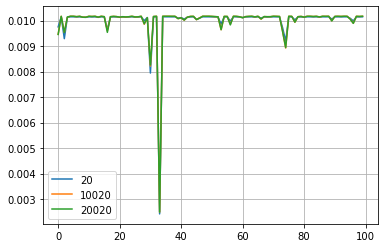

In [193]:
plt.plot(np.vstack(mean_scalar).T, label=sample_sizes)
plt.legend()
plt.grid()
plt.show()

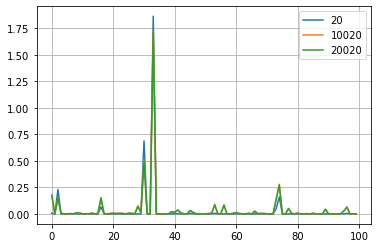

In [192]:
plt.plot(np.vstack(std_scalar).T, label=sample_sizes)
plt.legend()
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

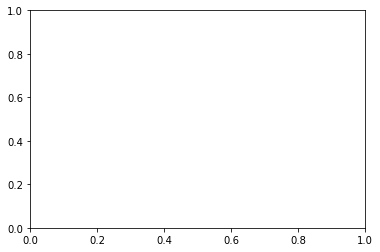

In [181]:
fig = plt.figure()
plt.plot(sample_sizes, acc, label="Analytical acc.")
plt.plot(sample_sizes, [real_acc]*len(sample_sizes), label="Monte Carlo acc.")

plt.legend()
plt.grid()
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.title("Estimator Accuracy")
plt.show()

In [ ]:
approx_entropy = np.sum(exp_s*np.log(exp_s+.001), axis=1)
approx_entropy

In [ ]:
final_shape = tuple([100] + exp_shape)
sampled_datapoints = norm(exp, var).rvs(size=final_shape)
softmax_output = tf.keras.activations.softmax(tf.convert_to_tensor(sampled_datapoints))
sample_acc = evaluate(softmax_output, y_train[:100])

In [ ]:
sampled_datapoints.shape

In [ ]:
sample_probs = tf.keras.activations.softmax(tf.convert_to_tensor(sampled_datapoints))

# mean_probs = np.mean(sample_probs, axis=0)
# sample_entropy = np.sum(mean_probs*np.log(mean_probs+.001), axis=-1)

sample_entropy = np.sum(sample_probs*np.log(sample_probs+.001), axis=-1)
sample_entropy = np.sum(sample_entropy, axis=0)/len(sample_entropy)

In [ ]:
sample_entropy.shape

In [ ]:
plt.plot(sample_entropy, label="Sample entropy")
plt.plot(approx_entropy, label="Approx. entropy")
plt.legend()
plt.plot()

## Condfidence interval

In [ ]:
# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
# https://blog.finxter.com/how-to-plot-the-confidence-interval-in-python/
import scipy.stats as st

In [ ]:
sample_probs = tf.keras.activations.softmax(tf.convert_to_tensor(sampled_datapoints))

In [ ]:
res = st.t.interval(0.95, len(sample_probs)-1, loc=np.mean(sample_probs, axis=0), scale=st.sem(sample_probs))